In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 761ms/step - loss: 73.2700 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 72.3807 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 71.2596 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 69.8434 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 68.2533 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 66.3086 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 64.2200 - mae: 64.7353
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 61.7602 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 0s 21ms/step - loss: 59.1640 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 0s 21ms/step - loss: 56.3343 - mae: 56.8317
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 22ms/step - loss: 35.2398 - mae: 36.5535
Epoch 87/100
8/8 [==============================] - 0s 21ms/step - loss: 24.6325 - mae: 25.2387
Epoch 88/100
8/8 [==============================] - 0s 22ms/step - loss: 15.0200 - mae: 15.5208
Epoch 89/100
8/8 [==============================] - 0s 22ms/step - loss: 11.6023 - mae: 11.9772
Epoch 90/100
8/8 [==============================] - 0s 22ms/step - loss: 13.1730 - mae: 13.7248
Epoch 91/100
8/8 [==============================] - 0s 21ms/step - loss: 13.0472 - mae: 13.7270
Epoch 92/100
8/8 [==============================] - 0s 22ms/step - loss: 21.0428 - mae: 22.1111
Epoch 93/100
8/8 [==============================] - 0s 22ms/step - loss: 24.2872 - mae: 25.2739
Epoch 94/100
8/8 [==============================] - 0s 21ms/step - loss: 19.3565 - mae: 19.4594
Epoch 95/100
8/8 [==============================] - 0s 22ms/step - loss: 22.1172 - mae: 22.1319
Epoch 96/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

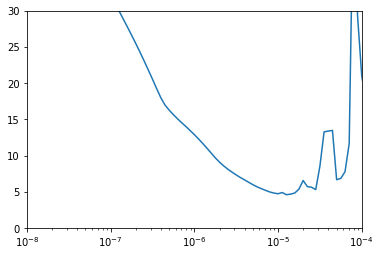

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 3s 90ms/step - loss: 21.5797 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 8.2290 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 6.6115 - mae: 7.1054
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 7.0621 - mae: 7.5361
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 6.0348 - mae: 6.5241
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 5.6423 - mae: 6.1262
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 5.4658 - mae: 5.9459
Epoch 8/500
31/31 [==============================] - 0s 9ms/step - loss: 5.3333 - mae: 5.8058
Epoch 9/500
31/31 [==============================] - 0s 9ms/step - loss: 5.2425 - mae: 5.7351
Epoch 10/500
31/31 [==============================] - 0s 9ms/step - loss: 5.2142 - mae: 5.6984
Epoch 11/500
31/31 [==============================] - 0s

31/31 [==============================] - 0s 9ms/step - loss: 4.2313 - mae: 4.7063
Epoch 88/500
31/31 [==============================] - 0s 9ms/step - loss: 4.3382 - mae: 4.8118
Epoch 89/500
31/31 [==============================] - 0s 9ms/step - loss: 4.2503 - mae: 4.7353
Epoch 90/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2821 - mae: 4.7546
Epoch 91/500
31/31 [==============================] - 0s 8ms/step - loss: 4.1844 - mae: 4.6611
Epoch 92/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2483 - mae: 4.7239
Epoch 93/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2083 - mae: 4.6805
Epoch 94/500
31/31 [==============================] - 0s 8ms/step - loss: 4.1755 - mae: 4.6382
Epoch 95/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1721 - mae: 4.6451
Epoch 96/500
31/31 [==============================] - 0s 8ms/step - loss: 4.1739 - mae: 4.6469
Epoch 97/500
31/31 [==============================] - 0s 8ms/st

31/31 [==============================] - 0s 8ms/step - loss: 4.0783 - mae: 4.5583
Epoch 173/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0861 - mae: 4.5582
Epoch 174/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0591 - mae: 4.5290
Epoch 175/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0454 - mae: 4.5193
Epoch 176/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1057 - mae: 4.5706
Epoch 177/500
31/31 [==============================] - 0s 8ms/step - loss: 4.1644 - mae: 4.6391
Epoch 178/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0762 - mae: 4.5395
Epoch 179/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0779 - mae: 4.5488
Epoch 180/500
31/31 [==============================] - 0s 8ms/step - loss: 4.3039 - mae: 4.7900
Epoch 181/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0965 - mae: 4.5735
Epoch 182/500
31/31 [==============================] -

31/31 [==============================] - 0s 9ms/step - loss: 4.0276 - mae: 4.5010
Epoch 257/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1049 - mae: 4.5861
Epoch 258/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1042 - mae: 4.5805
Epoch 259/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0764 - mae: 4.5458
Epoch 260/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9988 - mae: 4.4735
Epoch 261/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0493 - mae: 4.5136
Epoch 262/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0991 - mae: 4.5792
Epoch 263/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0587 - mae: 4.5259
Epoch 264/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0510 - mae: 4.5270
Epoch 265/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0154 - mae: 4.4913
Epoch 266/500
31/31 [==============================] -

31/31 [==============================] - 0s 9ms/step - loss: 4.0435 - mae: 4.5046
Epoch 342/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0381 - mae: 4.5215
Epoch 343/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0013 - mae: 4.4754
Epoch 344/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9819 - mae: 4.4520
Epoch 345/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0112 - mae: 4.4885
Epoch 346/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9774 - mae: 4.4481
Epoch 347/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9505 - mae: 4.4210
Epoch 348/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9673 - mae: 4.4369
Epoch 349/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9984 - mae: 4.4760
Epoch 350/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0217 - mae: 4.5020
Epoch 351/500
31/31 [==============================] -

31/31 [==============================] - 0s 9ms/step - loss: 3.9610 - mae: 4.4389
Epoch 427/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9257 - mae: 4.4005
Epoch 428/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9880 - mae: 4.4599
Epoch 429/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9761 - mae: 4.4526
Epoch 430/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9465 - mae: 4.4173
Epoch 431/500
31/31 [==============================] - 0s 8ms/step - loss: 4.0006 - mae: 4.4764
Epoch 432/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9385 - mae: 4.4126
Epoch 433/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9347 - mae: 4.4073
Epoch 434/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9696 - mae: 4.4373
Epoch 435/500
31/31 [==============================] - 0s 8ms/step - loss: 3.9388 - mae: 4.4083
Epoch 436/500
31/31 [==============================] 

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

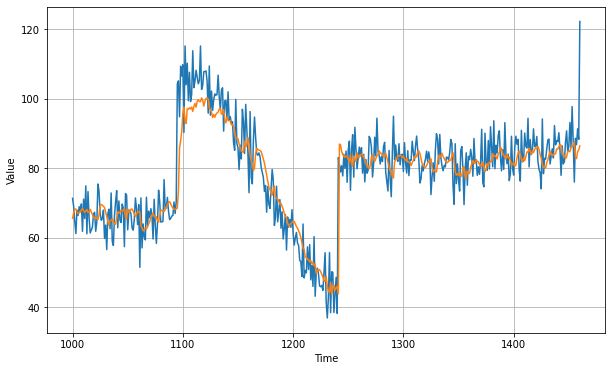

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.997589

<Figure size 432x288 with 0 Axes>

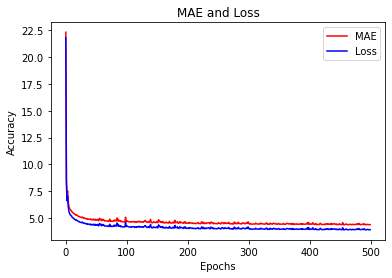

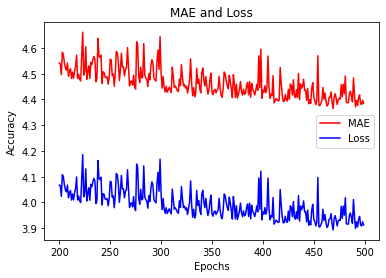

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()